In [2]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Load the dataset to inspect it and understand its structure, datatypes, and missing values
file_path = 'books_task.csv'
df = pl.read_csv(file_path)
# Convert each column to UTF-8
df = df.with_columns([pl.col(col).cast(pl.Utf8) for col in df.columns])
df = df.with_columns(
    pl.col("Impact").cast(pl.Float64).alias("Impact")
)
# Preview the data
preview = df.head()
columns_info = df.schema
null_counts = df.null_count().to_dict()
summary_stats = df.describe()

preview, columns_info, null_counts, summary_stats

(shape: (5, 8)
 ┌─────┬─────────────┬─────────────┬────────────┬────────────┬────────────┬────────────┬────────────┐
 │     ┆ Title       ┆ description ┆ authors    ┆ publisher  ┆ publishedD ┆ categories ┆ Impact     │
 │ --- ┆ ---         ┆ ---         ┆ ---        ┆ ---        ┆ ate        ┆ ---        ┆ ---        │
 │ str ┆ str         ┆ str         ┆ str        ┆ str        ┆ ---        ┆ str        ┆ f64        │
 │     ┆             ┆             ┆            ┆            ┆ str        ┆            ┆            │
 ╞═════╪═════════════╪═════════════╪════════════╪════════════╪════════════╪════════════╪════════════╡
 │ 0   ┆ Its Only    ┆ null        ┆ ['Julie    ┆ Smithsonia ┆ 1996       ┆ ['Comics & ┆ 784.303924 │
 │     ┆ Art If Its  ┆             ┆ Strain']   ┆ n Institut ┆            ┆ Graphic    ┆            │
 │     ┆ Well Hung!  ┆             ┆            ┆ ion        ┆            ┆ Novels']   ┆            │
 │ 1   ┆ Dr. Seuss:  ┆ Philip Nel  ┆ ['Philip   ┆ A&C Black  ┆ 2005

In [3]:
null_counts = df.select([pl.col(col).is_null().sum().alias(f"{col}_null_count") for col in df.columns])

null_counts

_null_count,Title_null_count,description_null_count,authors_null_count,publisher_null_count,publishedDate_null_count,categories_null_count,Impact_null_count
u32,u32,u32,u32,u32,u32,u32,u32
0,0,12749,2723,0,348,0,0


Step 1: Data Exploration and Initial Assessment
Here's a summary of the initial findings based on the data load:

Data Preview:

The dataset includes columns such as Title, description, authors, publisher, publishedDate, categories, and Impact.
A sample of records shows book titles, author names, categories, and an Impact score, which is likely the target variable.
Column Information:

The data types are primarily object (text) for descriptive fields like Title, authors, categories, and publisher.
Impact is a numerical field (float64), which will be key for further analysis.
publishedDate is currently in object format, indicating that date parsing may be necessary.
Missing Values Analysis:

description: 12,749 missing values.
authors: 2,723 missing values.
publishedDate: 348 missing values.
Other fields, such as Title, publisher, categories, and Impact, have no missing values.
We may need to decide on an imputation strategy, especially for description and authors, given their significant proportions of missing data.
Summary Statistics:

Impact ranges from 0 to 1000, with a mean of approximately 786.76.
The distribution of Impact appears to be skewed, with a standard deviation of around 63.64.

# **Data Cleaning and Preprocessing**
For authors ; description ; dates we made use of combination of calling openlibrary api to fill in the as much data as we can.

In [4]:
df = pl.read_csv("cleaned2.csv")
# Convert each column to UTF-8
df = df.with_columns([pl.col(col).cast(pl.Utf8) for col in df.columns])
df = df.with_columns(
    pl.col("Impact").cast(pl.Float64).alias("Impact")
)

In [5]:
import re
# Update 'publishedDate' column to retain only the year if found, otherwise set it to None
df = df.with_columns(
    pl.when(pl.col("publishedDate").cast(pl.Utf8).str.contains(r"\b(\d{4})\b"))
      .then(pl.col("publishedDate").cast(pl.Utf8).str.extract(r"(\d{4})"))
      .otherwise(None)
      .alias("publishedDate")
)
df.head()

Title,description,authors,publisher,publishedDate,categories,Impact
str,str,str,str,str,str,f64
"""Isaac Asimov: Master of Scienc…","""Details the life and career of…","""['Karen Judson']""","""Enslow Pub Incorporated""","""1998""","""['Juvenile Nonfiction']""",719.3797
"""White Rock Ways""","""Enjoy free will, but prepare f…","""['Rae Crossmon']""","""Rae Crossmon""","""2013""","""['Fiction']""",805.56854
"""The Face of the Third Reich""","""In these searing profiles the …","""['Joachim E. Fest']""","""Da Capo Press""","""1999""","""['History']""",805.56854
"""Victorian Gothic Designs (Inte…","""Designed by a master sculptor …","""['Ramona Jablonski']""","""Stemmer House Pub""","""1981""","""['Architecture']""",679.4883
"""The Best Short Stories of Edga…","""A complete collection of the w…","""['Edgar Allan Poe']""","""Bantam Books""","""1966""","""['Fiction']""",720.5101


In [6]:
null_counts = df.select([pl.col(col).is_null().sum().alias(f"{col}_null_count") for col in df.columns])

null_counts

Title_null_count,description_null_count,authors_null_count,publisher_null_count,publishedDate_null_count,categories_null_count,Impact_null_count
u32,u32,u32,u32,u32,u32,u32
0,10952,456,0,35,0,0


Null counts got reduced for the following :-


*   descrition from 12749 to 10954
*   Authors from 2723 to 455
*  published date from 348 to 34.

For the remaining null counts we will do the following:-

*  df.fillna({"description": "No Description", "authors":"Unknown author"}).
* for published date impute with the median.


In [7]:
df = df.with_columns([
    pl.col("Title").fill_null("No Title"),
    pl.col("description").fill_null("No Description"),
    pl.col("authors").fill_null("Unknown author")
])
df = df.with_columns(
    pl.col("publishedDate").cast(pl.Int64, strict=False).alias("publishedDate")
)

# Calculate the median of 'publishedDate' (ignoring nulls)
published_date_median = df.select(pl.col("publishedDate").median()).item()

# Fill null values in 'publishedDate' with the median
df = df.with_columns(
    pl.col("publishedDate").fill_null(published_date_median)
)
df.head(2)

Title,description,authors,publisher,publishedDate,categories,Impact
str,str,str,str,f64,str,f64
"""Isaac Asimov: Master of Scienc…","""Details the life and career of…","""['Karen Judson']""","""Enslow Pub Incorporated""",1998.0,"""['Juvenile Nonfiction']""",719.3797
"""White Rock Ways""","""Enjoy free will, but prepare f…","""['Rae Crossmon']""","""Rae Crossmon""",2013.0,"""['Fiction']""",805.56854


In [8]:
null_counts = df.select([pl.col(col).is_null().sum().alias(f"{col}_null_count") for col in df.columns])

null_counts

Title_null_count,description_null_count,authors_null_count,publisher_null_count,publishedDate_null_count,categories_null_count,Impact_null_count
u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0


In [9]:
# Checking for duplicates
df = df.unique(subset=['Title', 'authors', 'publishedDate'])

In [10]:
df.count()

Title,description,authors,publisher,publishedDate,categories,Impact
u32,u32,u32,u32,u32,u32,u32
138724,138724,138724,138724,138724,138724,138724


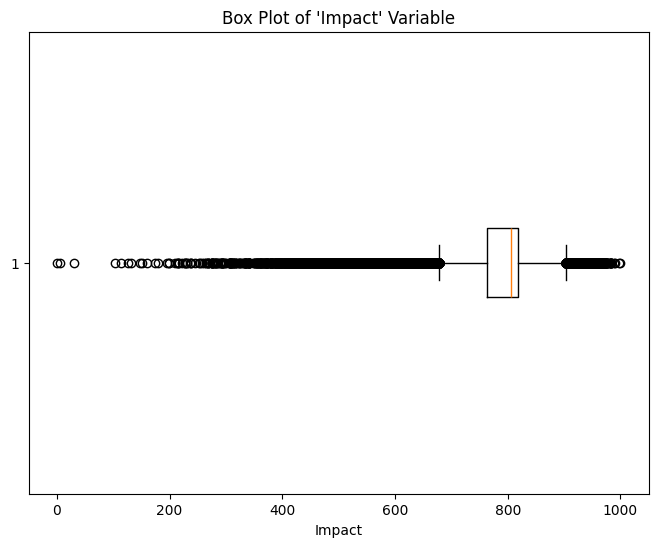

(678.9357400000001, 903.2119)

In [11]:
# Box plot for visual inspection of outliers in the 'Impact' column
plt.figure(figsize=(8, 6))
plt.boxplot(df['Impact'], vert=False)
plt.title("Box Plot of 'Impact' Variable")
plt.xlabel("Impact")
plt.show()

# Calculate Q1, Q3, and IQR
Q1 = df['Impact'].quantile(0.25)
Q3 = df['Impact'].quantile(0.75)
IQR = Q3 - Q1

# Determine outlier limits
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

lower_limit, upper_limit

The box plot indicates potential outliers in the Impact variable.

Outlier Limits:

Lower Limit: 679
Upper Limit: 903

Values below 679 or above 903 can be considered outliers based on the IQR method.

Treatment Options:
Log Transformation (most common for reducing skewness): This transformation is useful if Impact values are all positive. We’ll apply log(Impact + 1) to avoid issues with zero values.

In [12]:
df = df.with_columns(pl.when(pl.col("Impact") <= 0).then(0.1).otherwise(pl.col("Impact")).alias("Impact"))

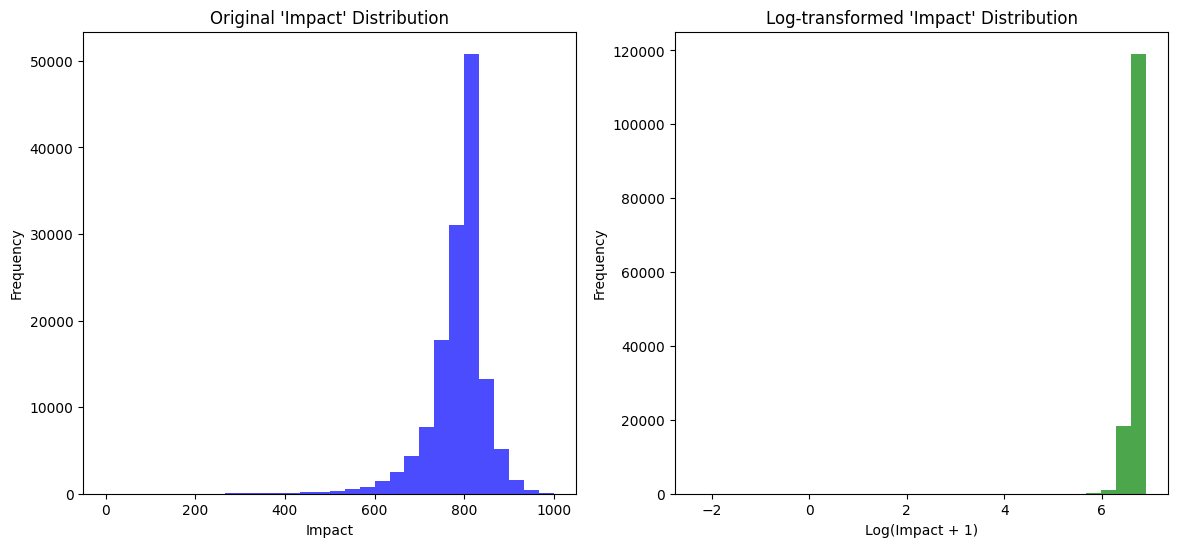

In [13]:
# Apply log transformation to the 'Impact' column
df = df.with_columns((pl.col("Impact").log().alias("log_Impact")))

# Plot the distribution of 'Impact' before and after transformation
plt.figure(figsize=(14, 6))

# Original 'Impact' Distribution
plt.subplot(1, 2, 1)
plt.hist(df['Impact'], bins=30, color='blue', alpha=0.7)
plt.title("Original 'Impact' Distribution")
plt.xlabel("Impact")
plt.ylabel("Frequency")

# Log-transformed 'Impact' Distribution
plt.subplot(1, 2, 2)
plt.hist(df['log_Impact'], bins=30, color='green', alpha=0.7)
plt.title("Log-transformed 'Impact' Distribution")
plt.xlabel("Log(Impact + 1)")
plt.ylabel("Frequency")


plt.show()

The histograms display the distribution of Impact before and after the log transformation:

Original Impact Distribution: Shows a wider spread with noticeable skewness.
Log-transformed Impact Distribution: The skewness is reduced, and values are more condensed, making the distribution less extreme.

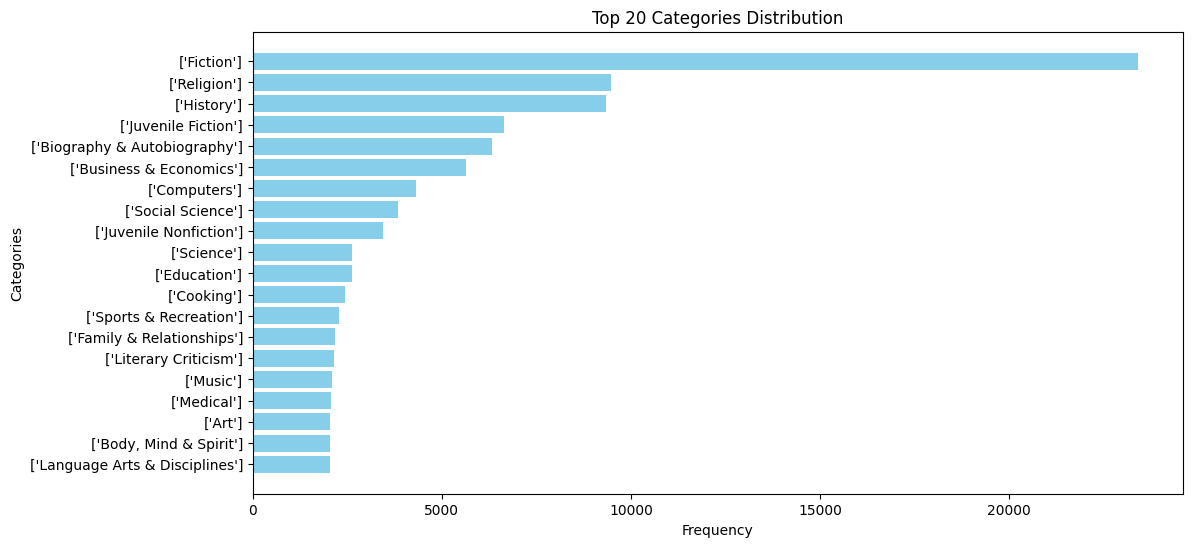

In [14]:
# Get the top 20 categories based on frequency
top_categories = df["categories"].value_counts(sort=True).limit(20)
# Convert the result to a format suitable for plotting
category_names = top_categories["categories"].to_list()
category_counts = top_categories["count"].to_list()

# Plot the top 20 categories
plt.figure(figsize=(12, 6))
plt.barh(category_names, category_counts, color="skyblue")
plt.xlabel("Frequency")
plt.ylabel("Categories")
plt.title("Top 20 Categories Distribution")
plt.gca().invert_yaxis()  # To display the highest frequency at the top
plt.show()

The bar plot highlights the most frequent categories. This distribution gives insight into which genres or categories dominate the dataset.

<ipython-input-15-0e3f9259e9d5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors["authors"], y=top_authors["count"], palette="magma")


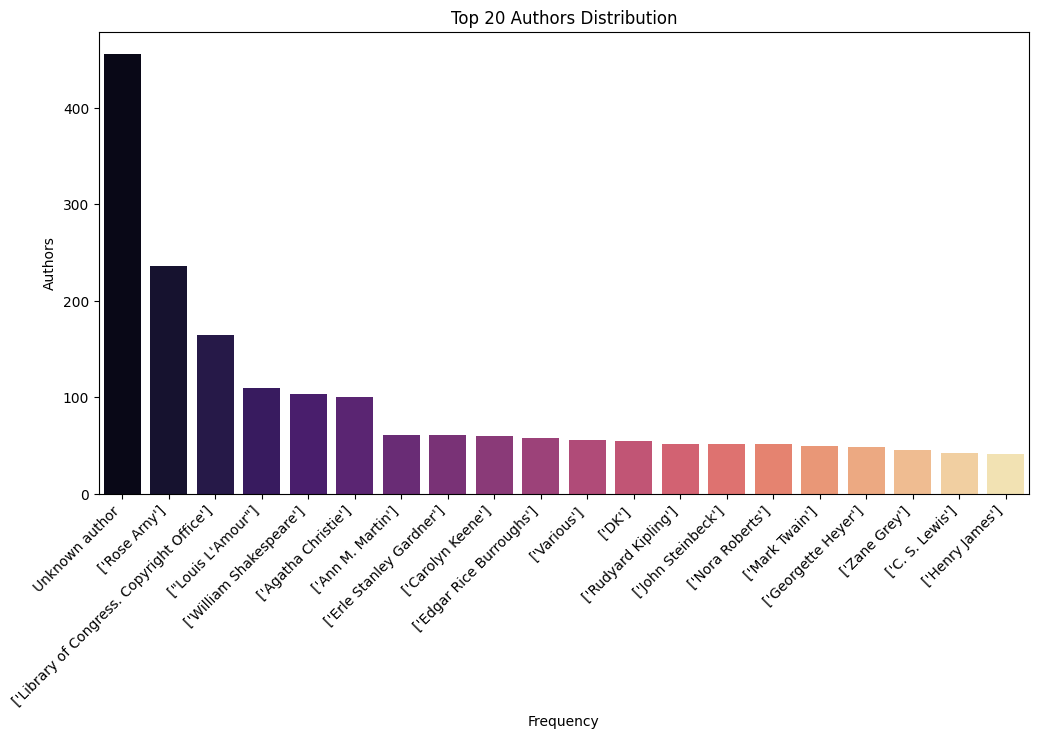

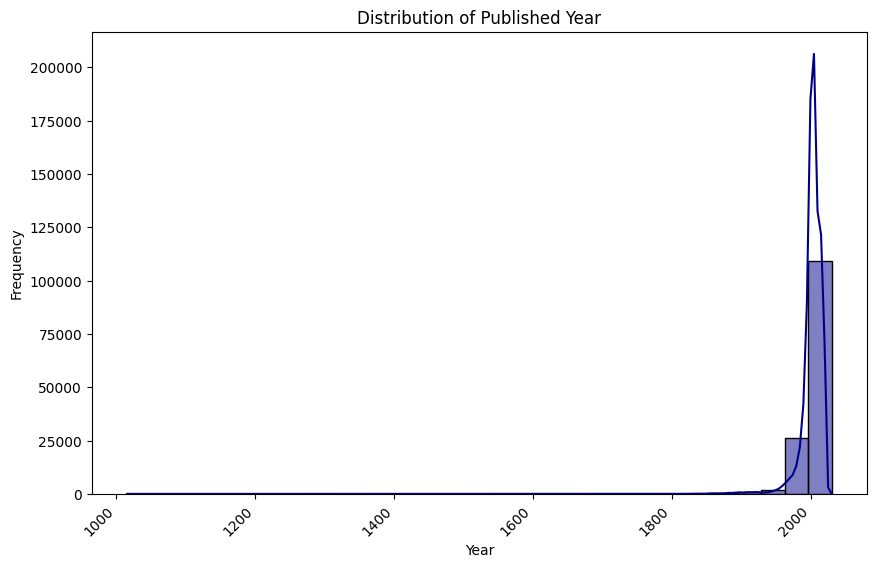

<ipython-input-15-0e3f9259e9d5>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_publishers["publisher"], y=top_publishers["count"], palette="viridis")


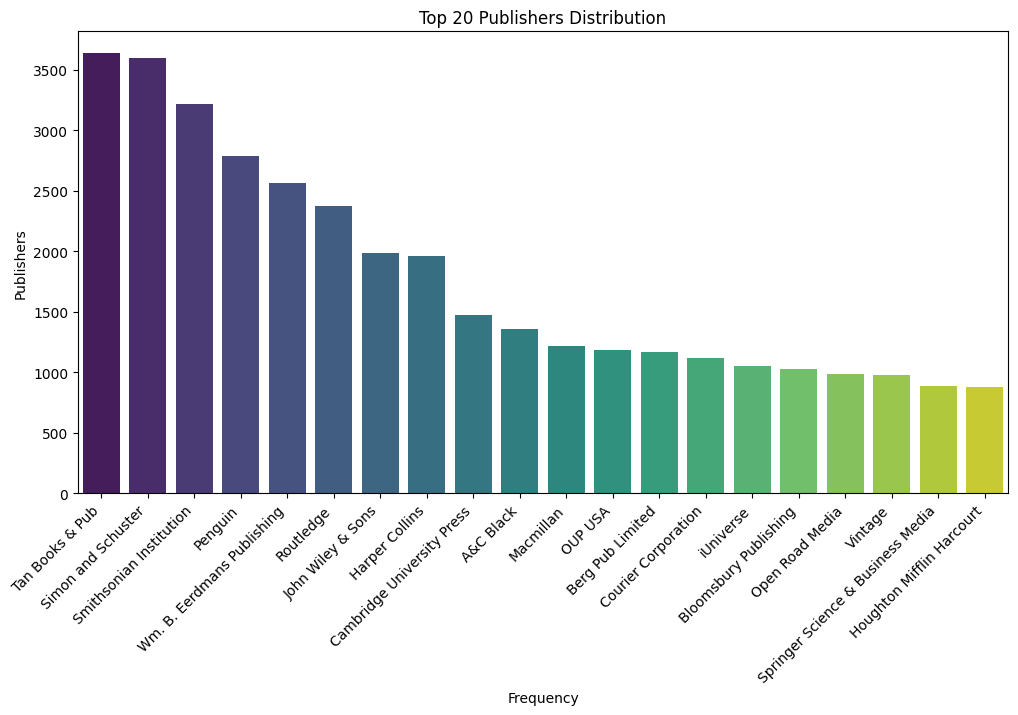

In [15]:
# 1. Top 20 Authors
top_authors = df['authors'].value_counts(sort=True).limit(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_authors["authors"], y=top_authors["count"], palette="magma")
plt.title("Top 20 Authors Distribution")
plt.xlabel("Frequency")
plt.ylabel("Authors")
plt.xticks(rotation=45, ha='right')
plt.show()

# 2. Published Year Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['publishedDate'], bins=30, kde=True, color="darkblue")
plt.title("Distribution of Published Year")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.show()

# 3. Top 20 Publishers
top_publishers = df['publisher'].value_counts(sort=True).limit(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_publishers["publisher"], y=top_publishers["count"], palette="viridis")
plt.title("Top 20 Publishers Distribution")
plt.xlabel("Frequency")
plt.ylabel("Publishers")
plt.xticks(rotation=45, ha='right')
plt.show()


Distribution of Published Year:
The histogram shows the spread of book publications over the years, highlighting potential trends in publishing activity over time.

Top 20 Authors:
The bar plot displays the most frequently occurring authors, giving insights into the most represented authors in the dataset.

Top 20 Publishers:
This plot reveals the most common publishers, showing which publishers have the largest presence.


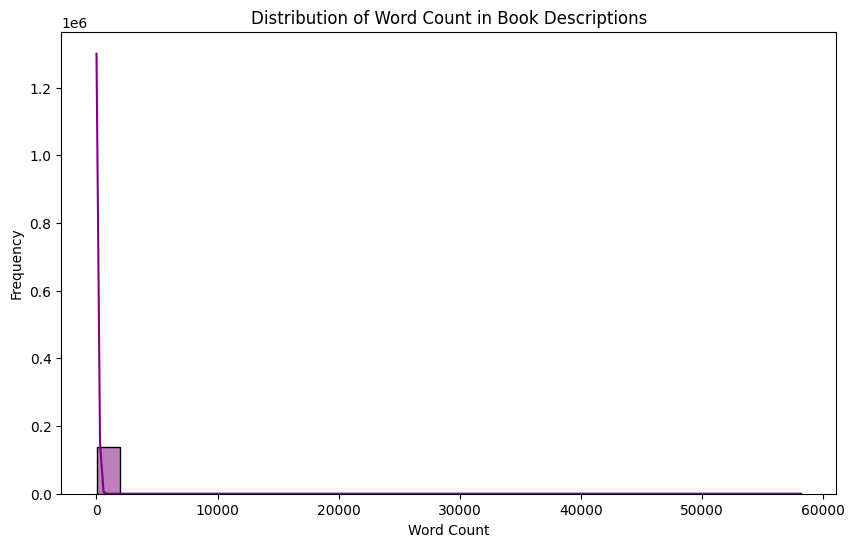

<ipython-input-17-d6f58dcbaa8c>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_word_count.values, y=category_word_count.index, palette="coolwarm")


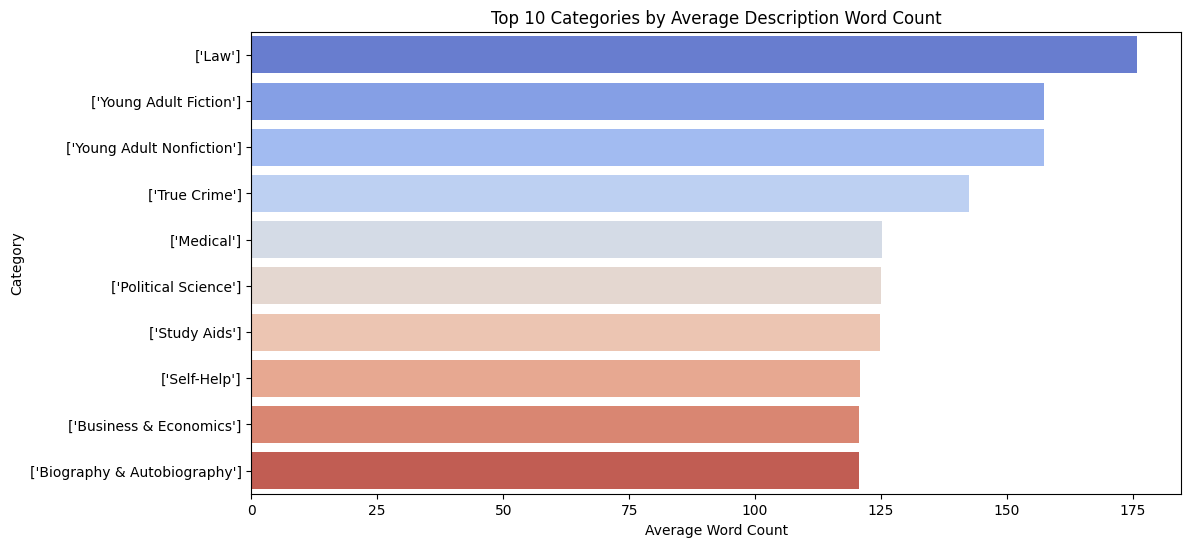

,description_word_count
count,138724.000000
mean,99.408322
std,184.207803
min,1.000000
25%,27.000000
50%,67.000000
75%,151.000000
max,58182.000000


In [17]:
df1 = df.to_pandas()
# Step 1: Statistical Summary of description_word_count
# Calculate word count for each book's description
df1['description_word_count'] = df1['description'].fillna('').apply(lambda x: len(x.split()))

description_word_count_summary = df1['description_word_count'].describe()

# Step 2: Visualization of description_word_count
plt.figure(figsize=(10, 6))
sns.histplot(df1['description_word_count'], bins=30, kde=True, color="purple")
plt.title("Distribution of Word Count in Book Descriptions")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# Step 3: Segmented Analysis - Average word count by category
# Calculate mean word count by primary category
category_word_count = df1.groupby(['categories'])['description_word_count'].mean().nlargest(10)

# Plot top 10 categories with the highest average description word count
plt.figure(figsize=(12, 6))
sns.barplot(x=category_word_count.values, y=category_word_count.index, palette="coolwarm")
plt.title("Top 10 Categories by Average Description Word Count")
plt.xlabel("Average Word Count")
plt.ylabel("Category")
plt.show()

# Display the summary statistics for description_word_count to the user
description_word_count_summary

1. Distribution of Word Count in Book Descriptions:-
The distribution of word counts in book descriptions is highly right-skewed, with the majority of descriptions containing relatively few words.(Empty values filled with No Description).

A few descriptions have extremely high word counts, which explains the stretched x-axis. Most descriptions fall within a much smaller range, creating a dense peak at the lower end of the scale.

This skew indicates that most descriptions are concise, while a small subset is highly detailed, possibly due to extensive summaries or content.

2. Top 10 Categories by Average Description Word Count

The chart shows the average description word count for the top 10 categories with the longest descriptions.

Law, Young Adult Fiction, and Young Adult Nonfiction categories have the highest average word counts, suggesting that books in these categories tend to have more detailed descriptions.

Categories like Biography & Autobiography and Business & Economics also have relatively high average word counts, likely because these genres require more context to explain the content effectively.


In [19]:
import polars as pl
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

df = df.with_columns(
    pl.col("description").str.to_lowercase()
)

# Convert the 'description' column to a pandas Series for compatibility with Scikit-Learn
df_pd = df.to_pandas()

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=20, stop_words="english")

# Fit and transform the descriptions
tfidf_matrix = tfidf_vectorizer.fit_transform(df["description"])

# Get the feature names (important words)
important_words = tfidf_vectorizer.get_feature_names_out()

# Sum TF-IDF scores for each word across all descriptions to find the most important terms overall
tfidf_scores = tfidf_matrix.sum(axis=0).A1
tfidf_word_scores = dict(zip(important_words, tfidf_scores))

# Convert to DataFrame for easy viewing and sorting
important_words_df = pd.DataFrame(tfidf_word_scores.items(), columns=["Word", "TF-IDF Score"]).sort_values(by="TF-IDF Score", ascending=False)

# Display the top 20 important words based on TF-IDF scores
print(important_words_df.head(20))


           Word  TF-IDF Score
3          book  19274.736707
12          new  14852.527802
10         life  12686.386436
4   description  11833.077187
18        world  11118.444634
8       history   7863.854589
15         time   7637.381042
17         work   7634.379514
7         guide   7386.523099
1        author   7342.124997
19        years   6664.811403
14        story   6482.561661
9     including   6460.826614
5       edition   6091.057224
0      american   6071.337778
13       people   5813.696238
11         love   5700.493069
2          best   5437.130304
6        family   5309.086862
16          war   5022.972762


# **Important Words by Category and Impact**

In [26]:
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Ensure you have downloaded the required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Define a function to preprocess text and extract word frequencies
def preprocess_text(text) -> str:
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())  # Tokenize and lower case
    filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
    return filtered_words

# Apply preprocessing and calculate word frequencies
df = df.with_columns([
    pl.col("description").map_elements(preprocess_text).alias("tokens")
])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-26-9b2a6eb18918>:19: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns([


ComputeError: cannot compare string with numeric type (u32)

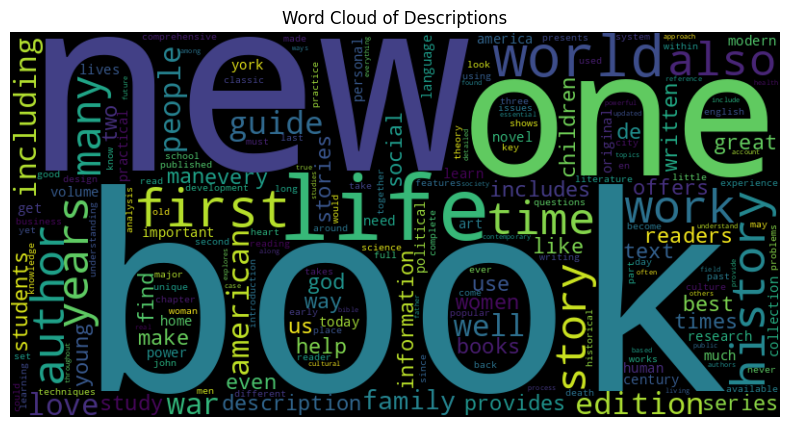

In [34]:
all_words = df.get_column("tokens").explode()
word_counts = all_words.value_counts(sort=True)

# Convert the word counts into a dictionary for the word cloud
word_counts_dict = dict(zip(word_counts['tokens'].to_list(), word_counts['count'].to_list()))

# Generate the word cloud from frequencies
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_counts_dict)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Descriptions")
plt.show()


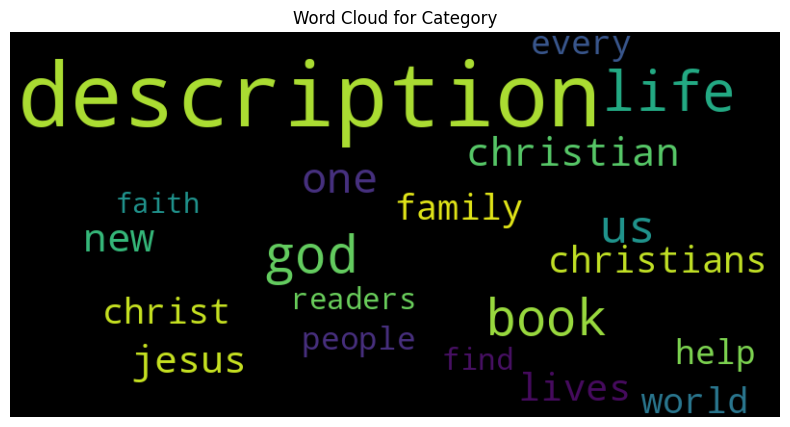

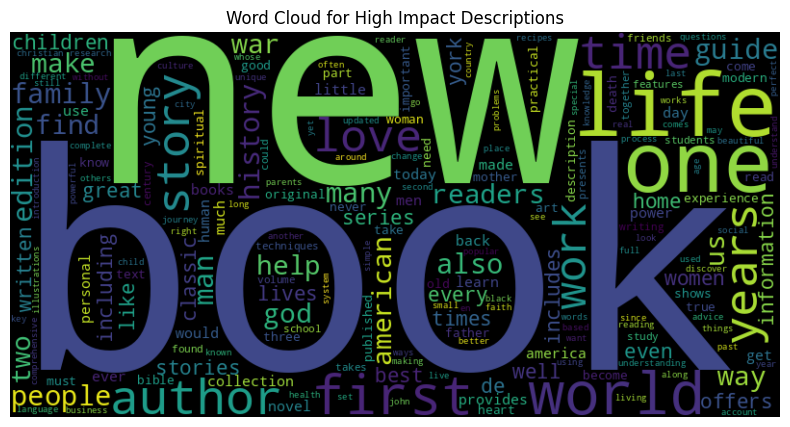

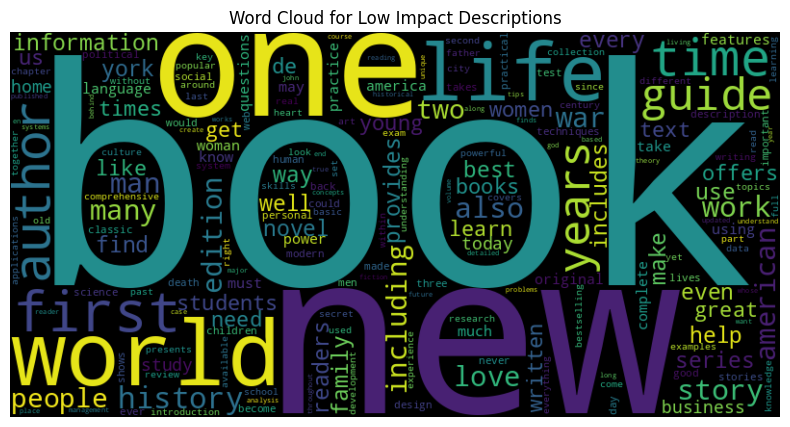

In [46]:
category_word_counts_df = category_word_counts.to_pandas()
word_counts_dict = dict(zip(category_word_counts_df['tokens'], category_word_counts_df['count']))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_counts_dict)
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"Word Cloud for Category")
plt.show()

# Analysis by Impact Levels (e.g., top 10% and bottom 10%)
# Adjust this threshold based on actual distribution
high_impact_words = df.filter(pl.col("Impact") >= df["Impact"].quantile(0.9))["tokens"].explode()
low_impact_words = df.filter(pl.col("Impact") <= df["Impact"].quantile(0.1))["tokens"].explode()

# High impact word cloud
high_impact_counts = high_impact_words.value_counts(sort=True)
word_counts_dict = dict(zip(high_impact_counts['tokens'], high_impact_counts['count']))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_counts_dict)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for High Impact Descriptions")
plt.show()

# Low impact word cloud
low_impact_counts = low_impact_words.value_counts(sort=False)
word_counts_dict = dict(zip(low_impact_counts['tokens'], low_impact_counts['count']))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_counts_dict)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Low Impact Descriptions")
plt.show()


1. General Word Cloud for Descriptions
Common words include "description," "book," "life," "god," "family," "people," and "Christian."
This indicates that many descriptions have a religious or spiritual tone, with terms like "god," "jesus," and "faith" appearing frequently.
Words like "family" and "life" suggest a focus on themes around personal growth, relationships, and spirituality.

2. Word Cloud for High Impact Descriptions Terms such as "new," "book," "life," "guide," "family," and "history" are prominent.
High-impact descriptions seem to focus on attributes like novelty ("new"), guidance ("guide"), and themes around "life" and "family."
Words like "love," "author," and "work" also appear frequently, possibly suggesting that high-impact books often emphasize relationships and self-development.

3. Word Cloud for Low Impact Descriptions
The prominent words here are quite similar to those in the high-impact descriptions, with words like "book," "life," "one," "guide," and "years."
However, the emphasis on "years" and "history" could suggest that low-impact descriptions might lean towards factual or historical content that may not resonate as widely.
The presence of words like "includes," "provides," and "system" could indicate a more informational tone, which might appeal less in terms of engagement.


# Categories vs Impact

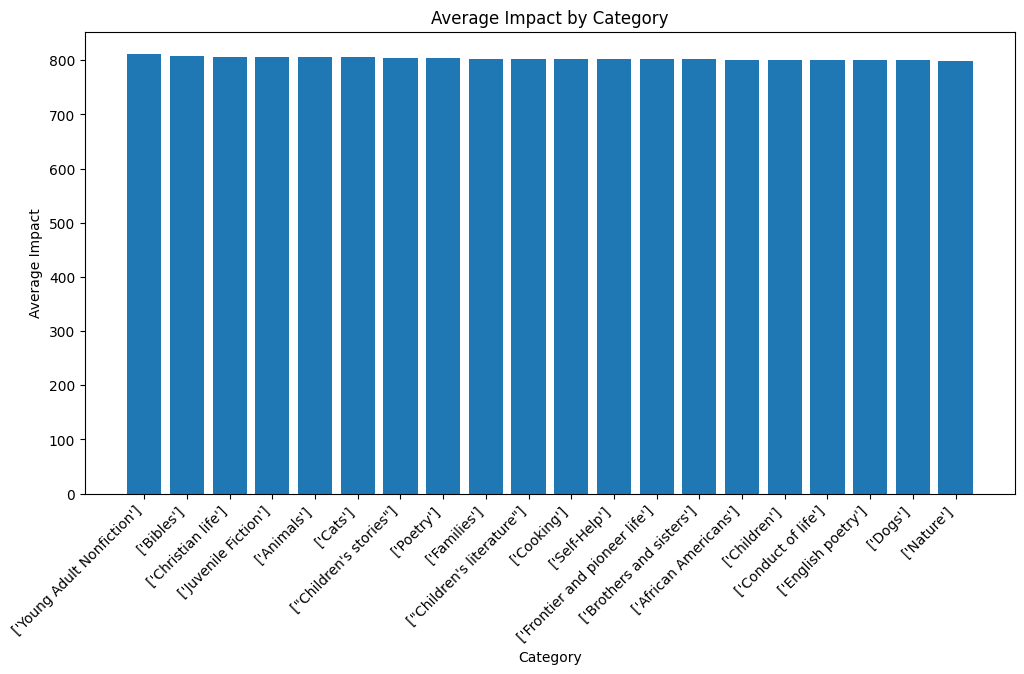

In [54]:
# Calculate average impact by category
impact_by_category = df.group_by("categories").agg(pl.col("Impact").mean().alias("avg_impact")).sort("avg_impact", descending=True).limit(20)

# Plot average impact by category
impact_by_category_df = impact_by_category.to_pandas()
plt.figure(figsize=(12, 6))
plt.bar(impact_by_category_df["categories"], impact_by_category_df["avg_impact"])
plt.xticks(rotation=90)
plt.xlabel("Category")
plt.ylabel("Average Impact")
plt.title("Average Impact by Category")
plt.xticks(rotation=45, ha='right')
plt.show()

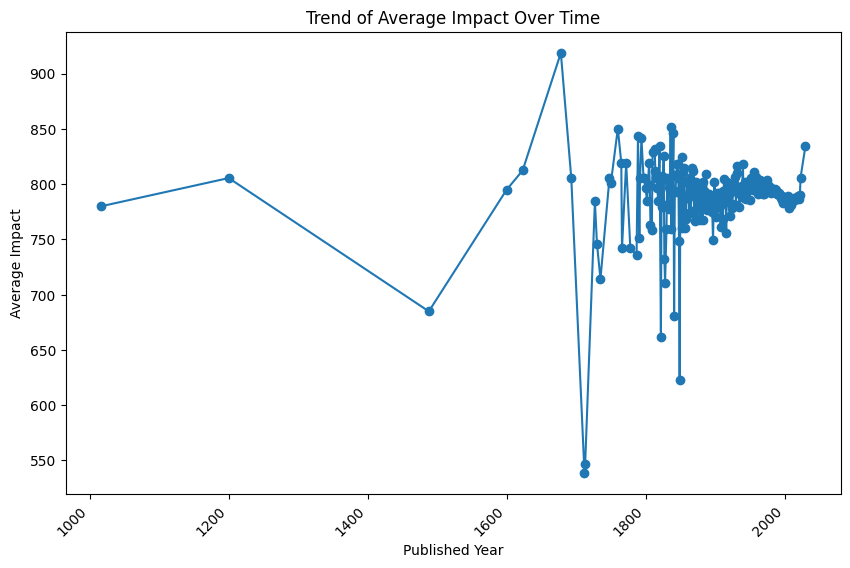

In [58]:
# Calculate average impact per year
impact_by_year = df.group_by("publishedDate").agg(pl.col("Impact").mean().alias("avg_impact")).sort("publishedDate")

# Plot average impact over time
impact_by_year_df = impact_by_year.to_pandas()
plt.figure(figsize=(10, 6))
plt.plot(impact_by_year_df["publishedDate"], impact_by_year_df["avg_impact"], marker='o')
plt.xlabel("Published Year")
plt.ylabel("Average Impact")
plt.title("Trend of Average Impact Over Time")
plt.xticks(rotation=45, ha='right')
plt.show()

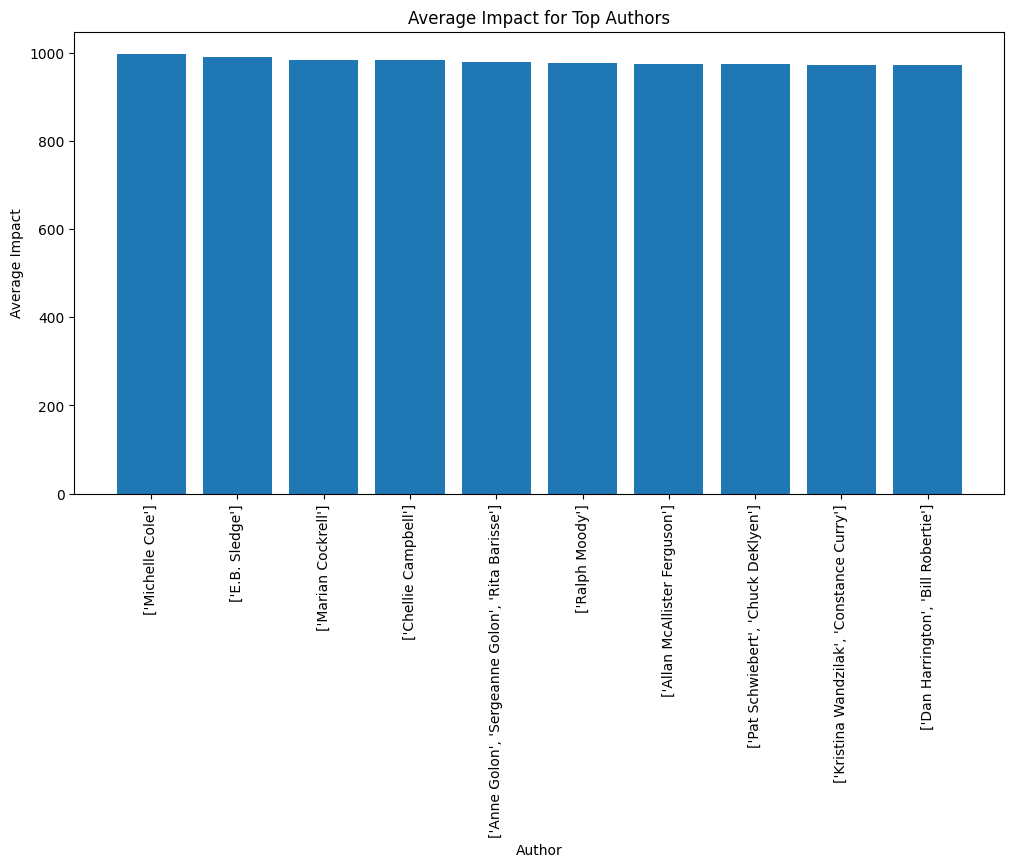

In [59]:
# Calculate average impact by author
impact_by_author = df.group_by("authors").agg(pl.col("Impact").mean().alias("avg_impact")).sort("avg_impact", descending=True)

# Filter top authors based on the number of books or impact (e.g., top 10)
top_authors = impact_by_author.head(10).to_pandas()

# Plot average impact for top authors
plt.figure(figsize=(12, 6))
plt.bar(top_authors["authors"], top_authors["avg_impact"])
plt.xticks(rotation=90)
plt.xlabel("Author")
plt.ylabel("Average Impact")
plt.title("Average Impact for Top Authors")
plt.show()


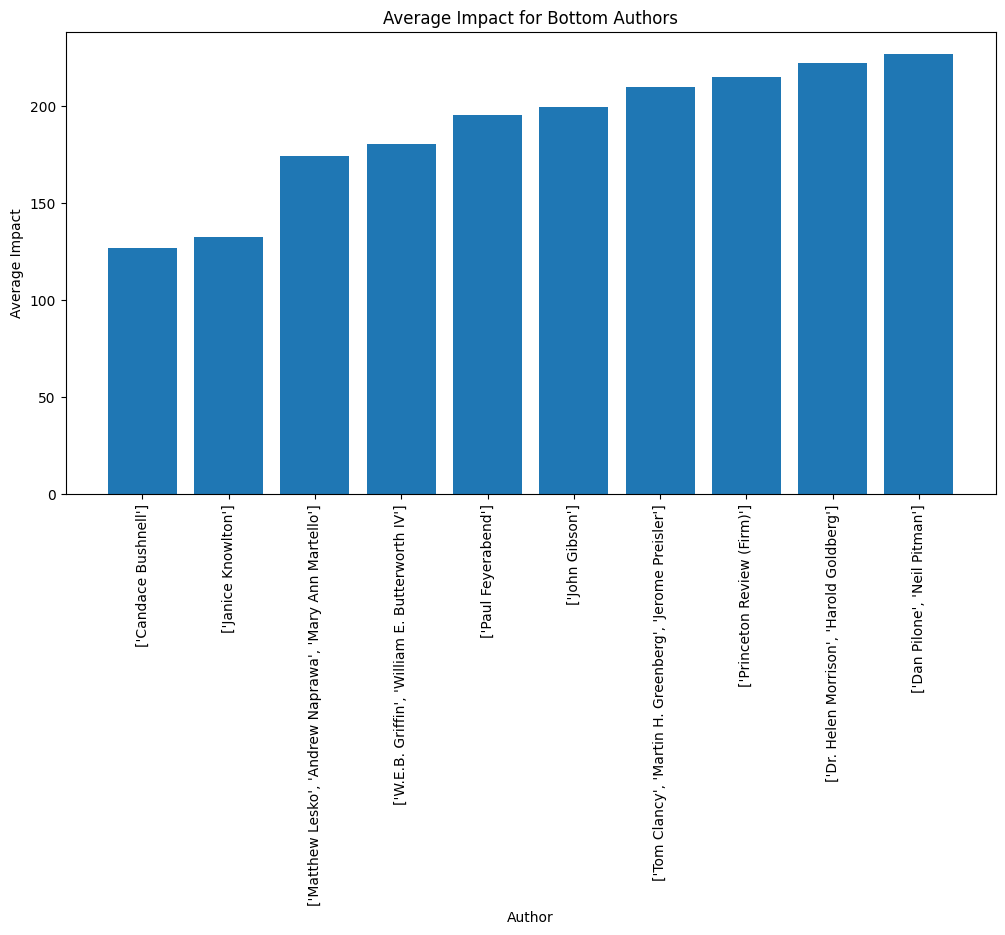

In [62]:
# Calculate average impact by author
impact_by_author = df.group_by("authors").agg(pl.col("Impact").mean().alias("avg_impact")).sort("avg_impact", descending=False)

# Filter top authors based on the number of books or impact (e.g., top 10)
top_authors = impact_by_author.head(10).to_pandas()

# Plot average impact for top authors
plt.figure(figsize=(12, 6))
plt.bar(top_authors["authors"], top_authors["avg_impact"])
plt.xticks(rotation=90)
plt.xlabel("Author")
plt.ylabel("Average Impact")
plt.title("Average Impact for Bottom Authors")
plt.show()


1. Average Impact by Category

The bar plot shows a uniformity in average impact across categories, with all categories appearing to have similar values (around 800).
This might suggest that the impact measure doesn’t significantly vary between categories.
It could imply that the impact score might be more influenced by other factors like author popularity, publication date, or description content, rather than the category alone.
Alternatively, the lack of variability could indicate potential data normalization or similar treatment of impact values across different **categories, potentially making category-based distinctions less pronounced.**

2. Trend of Average Impact Over Time
The line plot for average impact over time reveals some interesting patterns, especially:
A sharp drop and rise in earlier years (around 1600-1800), which could be an artifact due to a smaller number of publications from those periods.
After 1800, the impact scores become more stable with some variations, suggesting more consistency in book popularity or engagement metrics in modern times.
In recent years, the impact appears to fluctuate around a mean level, indicating that there isn’t a strong trend toward higher or lower impact based purely on recent publication years.
These findings may imply that older books might either have extreme popularity or be less relevant, leading to this erratic behavior in impact scores.


3. Average Impact for Top Authors
The bar plot for top authors shows very high and uniform impact scores, all close to 1000.
This uniformity suggests that these authors have consistently high-impact books, likely indicating their established popularity or a dedicated readership.
Given that impact scores are high across these authors, it may reflect an inherent preference among readers for these specific authors or their writing styles.

4. Average Impact for Bottom Authors
The bottom authors show a more varied distribution of average impact scores, ranging from approximately 100 to just above 200.
Unlike the top authors, who have consistently high impact, these authors display lower and more varied popularity, which could suggest that their works are either niche or appeal to a smaller audience.
This variation among the bottom authors might be useful in identifying unique or niche genres or topics that may have dedicated but smaller readerships.

# **Summary**
1. Category: Impact scores do not vary significantly across categories,suggesting that the category itself may not be a primary determinant of impact.

2. Time: There are fluctuations in the earlier years, potentially due to fewer books, but modern publications show a relatively stable trend.

3. Authors: There’s a clear distinction between top and bottom authors, with top authors maintaining high impact scores, while bottom authors have more variability and lower averages.

# Multi-Variate Analysis

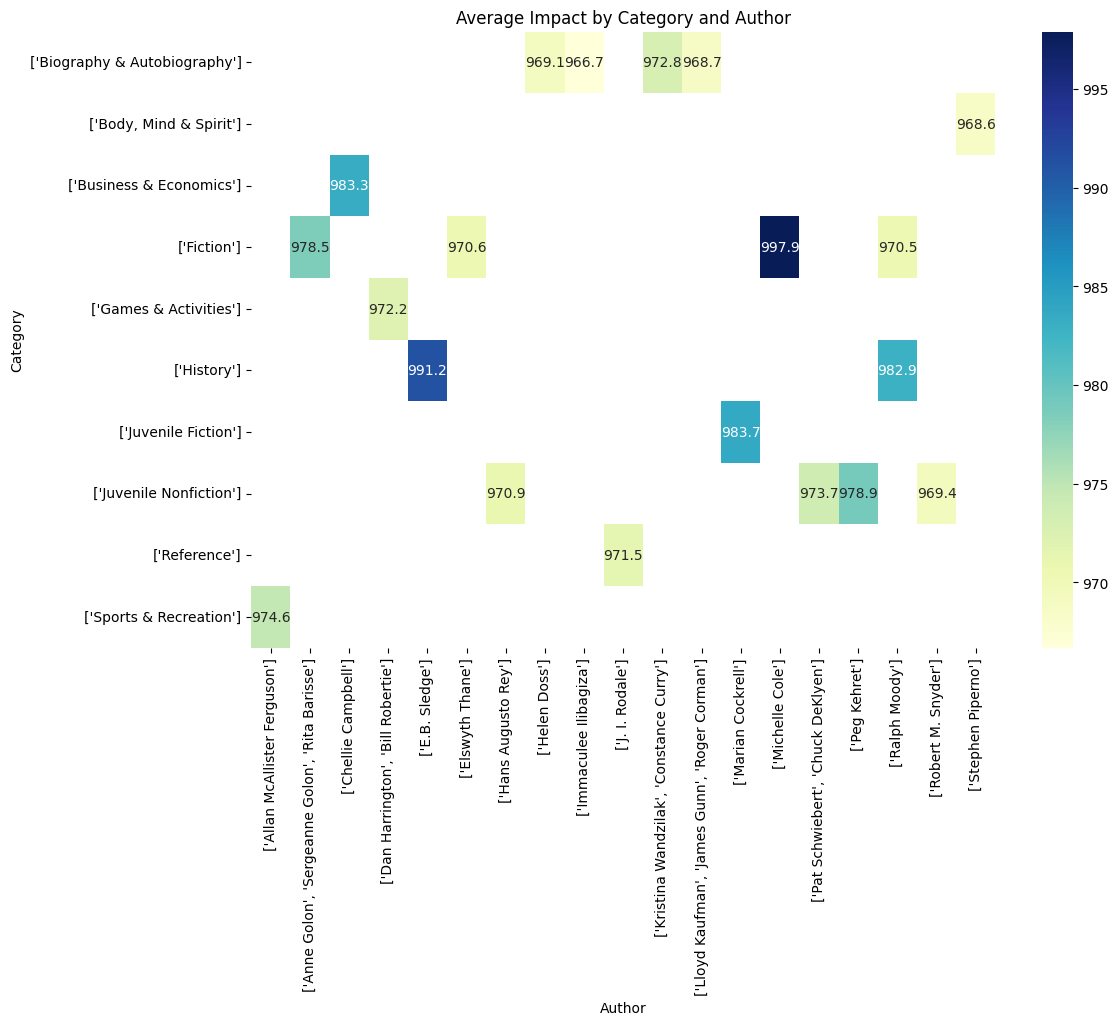

In [76]:
### Step 1: Combined Influence of Category and Author on Impact
# Group by Category and Author, and calculate average impact
impact_by_cat_author = df.group_by(["categories", "authors"]).agg(
    pl.col("Impact").mean().alias("avg_impact")
).sort("avg_impact", descending=True)

# Convert to pandas for visualization
impact_by_cat_author_df = impact_by_cat_author.to_pandas()

# Filter top combinations for visualization (e.g., top 20)
top_cat_author = impact_by_cat_author_df.head(20)

# Plot heatmap
plt.figure(figsize=(12, 8))
top_cat_author_pivot = top_cat_author.pivot(index="categories", columns="authors", values="avg_impact")
sns.heatmap(top_cat_author_pivot, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average Impact by Category and Author")
plt.xlabel("Author")
plt.ylabel("Category")
plt.show()


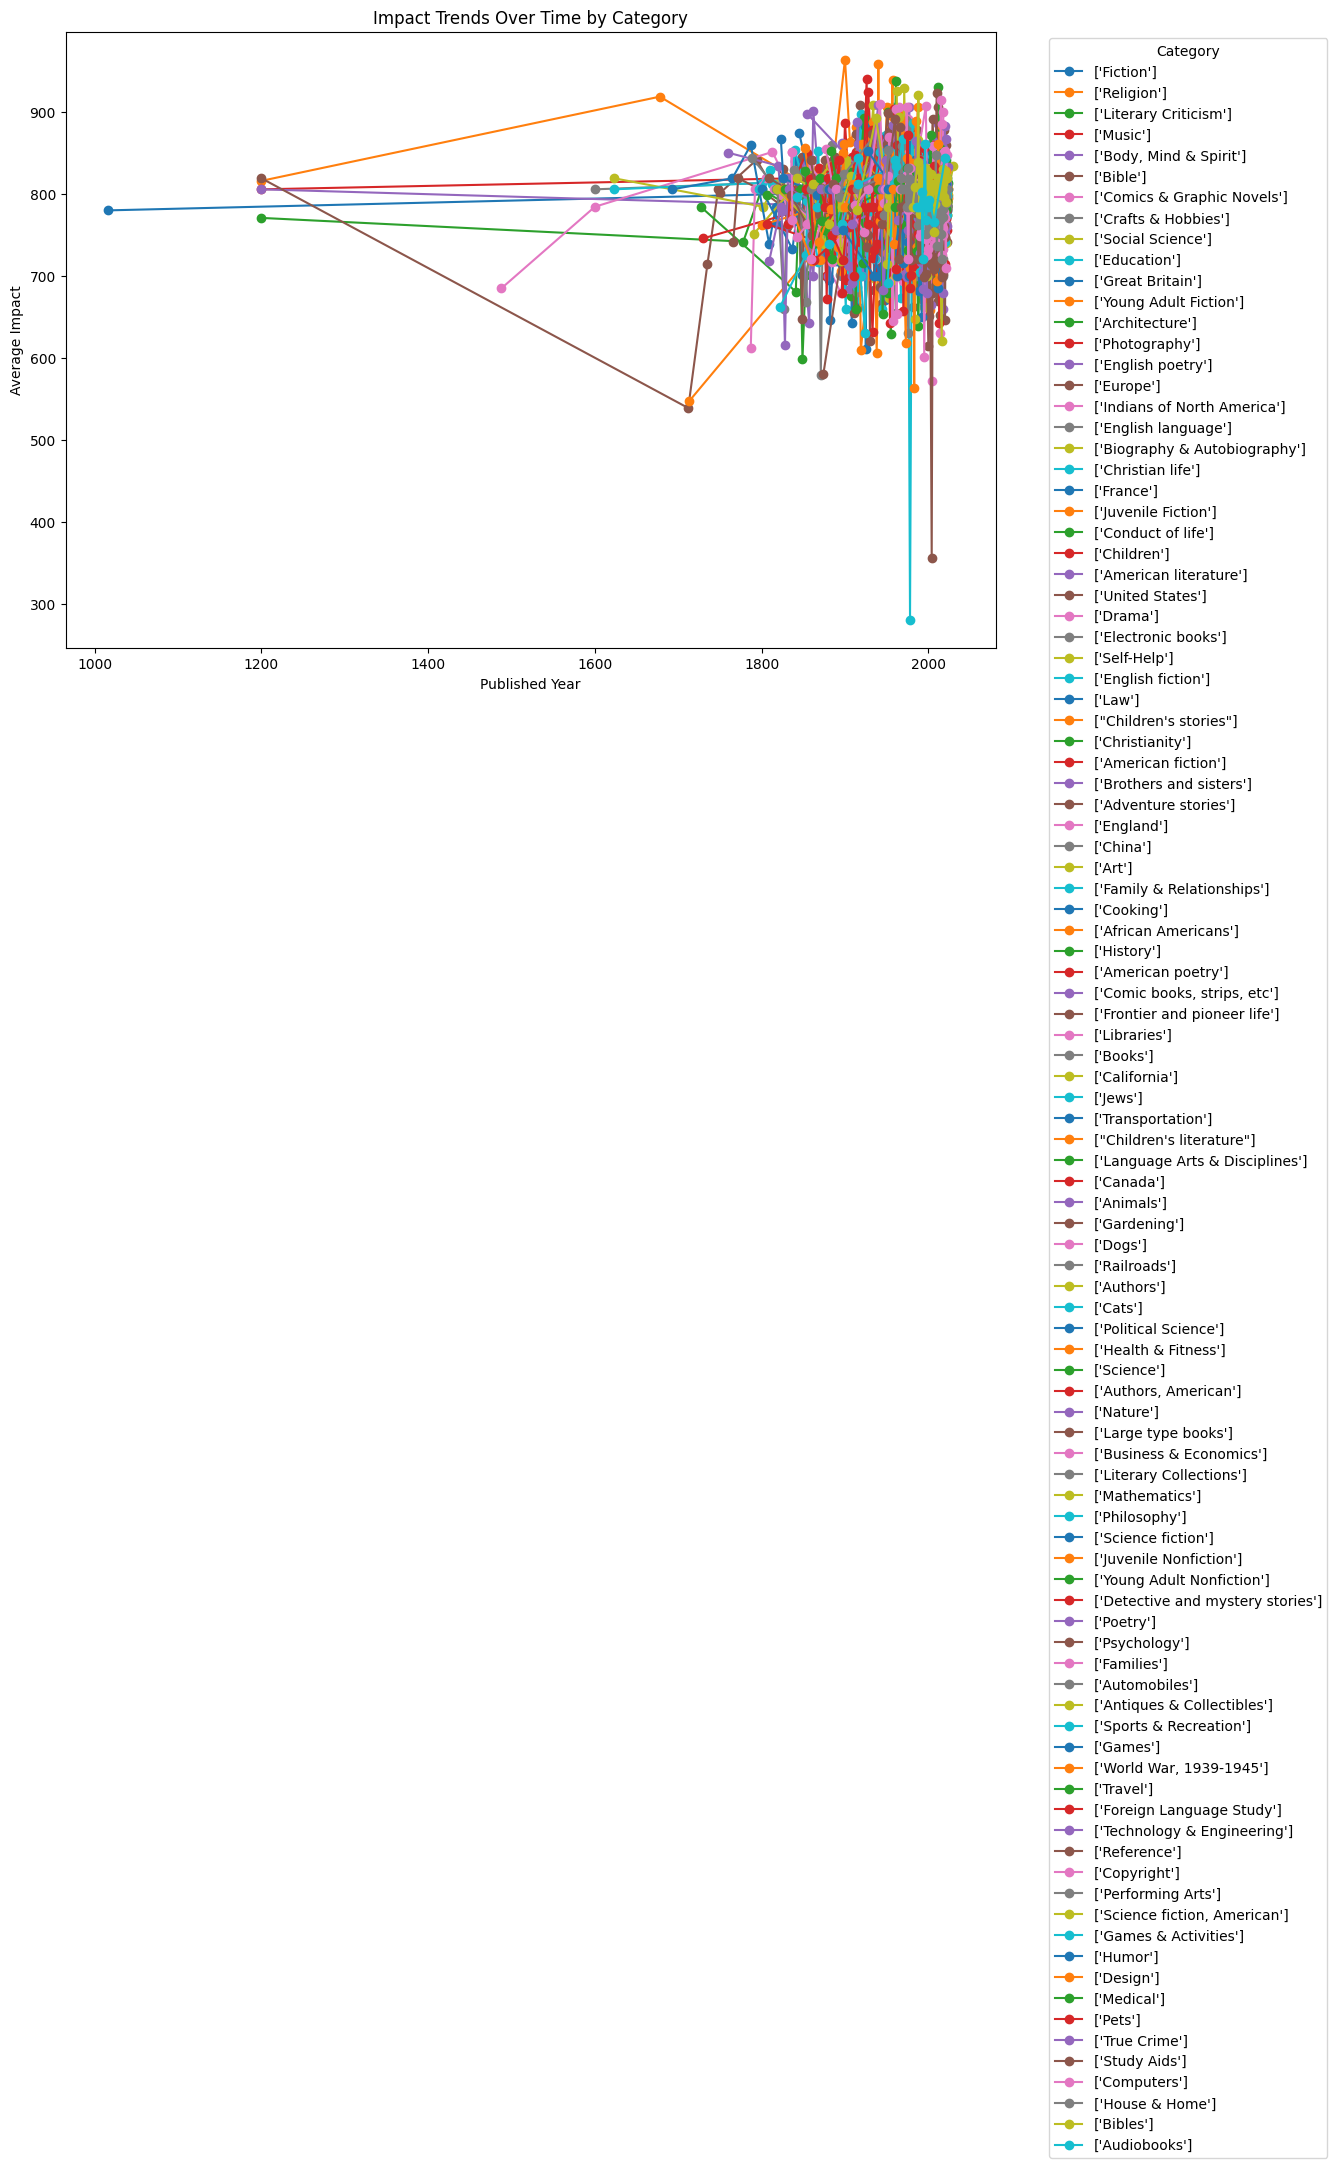

In [77]:

### Step 2: Impact, Category, and Year
# Extract year from published_date if it exists in a datetime format
data = df
# Group by Category and Year to calculate average impact
impact_by_cat_year = data.group_by(["categories", "publishedDate"]).agg(
    pl.col("Impact").mean().alias("avg_impact")
).sort("publishedDate")

# Convert to pandas for visualization
impact_by_cat_year_df = impact_by_cat_year.to_pandas()

# Plot line plot for each category over time
plt.figure(figsize=(12, 8))
for category in impact_by_cat_year_df['categories'].unique():
    category_data = impact_by_cat_year_df[impact_by_cat_year_df['categories'] == category]
    plt.plot(category_data["publishedDate"], category_data["avg_impact"], marker='o', label=category)

plt.title("Impact Trends Over Time by Category")
plt.xlabel("Published Year")
plt.ylabel("Average Impact")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

1. Category and Author Influence:
Both category and author significantly influence the impact score.
Certain authors have established themselves within specific categories, resulting in higher engagement.
This insight can guide recommendations or promotions, where publishers may want to emphasize the works of specific authors within particular genres.

2. Temporal Trends by Category:
The stability of impact in recent years suggests that readers are consistent in their engagement with certain categories.
Categories with notable upward or downward trends could help publishers identify emerging or declining reader interests. For instance, categories showing rising trends may benefit from increased publication efforts or targeted marketing.

3. Potential for Targeted Strategies:
The insights derived from both the category-author heatmap and temporal trends can be used to develop strategies for content personalization, such as focusing on high-impact author-category pairings or emphasizing genres with stable impact scores.